In [16]:
import random
import shutil
import os
from imutils import paths

# Set up paths for original images and training/validation/test
ORIGINAL_IMAGES = "dataset/images"
TRAINING_PATH = "dataset/training"
VALIDATION_PATH = "dataset/validation"
TESTING_PATH = "dataset/testing"

# Define the percentage of images used in training (80%),
# and the amount of validation data
TRAINING_SPLIT = 0.8
VALIDATION_SPLIT = 0.1

In [17]:
# Access and shuffle original images
imagePaths = list(paths.list_images(ORIGINAL_IMAGES))
random.seed(42)
random.shuffle(imagePaths)

# Compute the training and testing split
i = int(len(imagePaths) * TRAINING_SPLIT)
trainingPaths = imagePaths[:i]
testingPaths = imagePaths[i:]

# Use part of the training data for validation
i = int(len(trainingPaths) * VALIDATION_SPLIT)
validationPaths = trainingPaths[:i]
trainingPaths = trainingPaths[i:]

# Define the datasets
datasets = [
  ("training", trainingPaths, TRAINING_PATH),
  ("validation", validationPaths, VALIDATION_PATH),
  ("testing", testingPaths, TESTING_PATH)
]

In [18]:
for (dType, imagePaths, baseOutput) in datasets:
  # If output directory doesn't exit, create it
  if not os.path.exists(baseOutput):
    os.makedirs(baseOutput)
    
  # Loop over the input image paths
  for inputPath in imagePaths:
    # Extract the filename of the input image along with its
    # corresponding class label
    filename = inputPath.split(os.path.sep)[-1]
    label = inputPath.split(os.path.sep)[-2]
    # Build the path to the label directory
    labelPath = os.path.sep.join([baseOutput, label])
    # If label output directory doesn't exist, create it
    if not os.path.exists(labelPath):
      os.makedirs(labelPath)

    # Construct the path to the destination image and then copy
    # the image itself
    p = os.path.sep.join([labelPath, filename])
    shutil.copy2(inputPath, p)

In [19]:
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD
from pyimagesearch.resnet import ResNet
from sklearn.metrics import classification_report
from imutils import paths
import cv2
import numpy as np

NUM_EPOCHS = 30
BATCH_SIZE = 32

TRAINING_PATH = "dataset/training"
VALIDATION_PATH = "dataset/validation"
TESTING_PATH = "dataset/testing"
MODEL_NAME = "streetart_classifer.model"

# Determine the total number of image paths in training, validation,
# and testing directories
totalTrain = len(list(paths.list_images(TRAINING_PATH)))
totalVal = len(list(paths.list_images(VALIDATION_PATH)))
totalTest = len(list(paths.list_images(TESTING_PATH)))

#!pip install tensorflow --upgrade --force-reinstall

In [20]:
# Initialize the training training data augmentation object
trainAug = ImageDataGenerator(
  rescale=1 / 255.0,
  rotation_range=20,
  zoom_range=0.05,
  width_shift_range=0.05,
  height_shift_range=0.05,
  shear_range=0.05,
  horizontal_flip=True,
  fill_mode="nearest")
  
# Initialize the validation (and testing) data augmentation object
valAug = ImageDataGenerator(rescale=1 / 255.0)

In [21]:
# Initialize the training generator
trainGen = trainAug.flow_from_directory(
  TRAINING_PATH,
  class_mode="categorical",
  target_size=(64, 64),
  color_mode="rgb",
  shuffle=True,
  batch_size=BATCH_SIZE)
  
# Initialize the validation generator
valGen = valAug.flow_from_directory(
  VALIDATION_PATH,
  class_mode="categorical",
  target_size=(64, 64),
  color_mode="rgb",
  shuffle=False,
  batch_size=BATCH_SIZE)
  
# Initialize the testing generator
testGen = valAug.flow_from_directory(
  TESTING_PATH,
  class_mode="categorical",
  target_size=(64, 64),
  color_mode="rgb",
  shuffle=False,
  batch_size=BATCH_SIZE)

Found 4511 images belonging to 2 classes.
Found 501 images belonging to 2 classes.
Found 1254 images belonging to 2 classes.


In [22]:
# Initialize our Keras implementation of ResNet model and compile it
model = ResNet.build(64, 64, 3, 2, (2, 2, 3),
  (32, 64, 128, 256), reg=0.0005)
opt = SGD(lr=1e-1, momentum=0.9, decay=1e-1 / NUM_EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
  metrics=["accuracy"])

  # Train our Keras model
H = model.fit_generator(
  trainGen,
  steps_per_epoch=totalTrain // BATCH_SIZE,
  validation_data=valGen,
  validation_steps=totalVal // BATCH_SIZE,
  epochs=NUM_EPOCHS
)

  
# Reset the testing generator and then use our trained model to
# make predictions on the data
print("[INFO] evaluating network...")
testGen.reset()
predIdxs = model.predict_generator(testGen,
  steps=(totalTest // BATCH_SIZE) + 1)

  
# For each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)
# show a nicely formatted classification report
print(classification_report(testGen.classes, predIdxs,
  target_names=testGen.class_indices.keys()))

Epoch 1/30
140/140 [==============================] - 170s 1s/step - loss: 0.8973 - accuracy: 0.6495 - val_loss: 0.7432 - val_accuracy: 0.7167
Epoch 2/30
140/140 [==============================] - 168s 1s/step - loss: 0.7465 - accuracy: 0.7013 - val_loss: 0.6687 - val_accuracy: 0.7771
Epoch 3/30
140/140 [==============================] - 169s 1s/step - loss: 0.7219 - accuracy: 0.7144 - val_loss: 0.6983 - val_accuracy: 0.7729
Epoch 4/30
140/140 [==============================] - 173s 1s/step - loss: 0.7030 - accuracy: 0.7223 - val_loss: 0.8390 - val_accuracy: 0.6083
Epoch 5/30
140/140 [==============================] - 175s 1s/step - loss: 0.6826 - accuracy: 0.7292 - val_loss: 0.7526 - val_accuracy: 0.6833
Epoch 6/30
140/140 [==============================] - 173s 1s/step - loss: 0.6680 - accuracy: 0.7493 - val_loss: 0.6558 - val_accuracy: 0.7583
Epoch 7/30
140/140 [==============================] - 169s 1s/step - loss: 0.6666 - accuracy: 0.7450 - val_loss: 0.7379 - val_accuracy: 0.6917

In [23]:
# Save the neural network to disk
print("[INFO] serializing network to '{}'...".format(MODEL_NAME))
model.save(MODEL_NAME)

[INFO] serializing network to 'streetart_classifer.model'...
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: streetart_classifer.model/assets


In [24]:
from keras.preprocessing.image import img_to_array
from keras.models import load_model
import numpy as np
import random
import cv2
from imutils import build_montages
from IPython.display import Image

In [75]:
MODEL_NAME = 'save_model.model'
MONTAGE_FILENAME = 'streetart_photo.png'
IMAGES_PATH = 'dataset/testing'

model = load_model(MODEL_NAME)

imagePaths = list(paths.list_images(IMAGES_PATH))
random.shuffle(imagePaths)
imagePaths = imagePaths[:1]

# initialize our list of results
results = []

In [76]:
# loop over our sampled image paths
print("[INFO] evaluating model against test set...")
for p in imagePaths:
        # load our original input image
        orig = cv2.imread(p)

        # pre-process our image by converting it from BGR to RGB channel
        # ordering (since our Keras mdoel was trained on RGB ordering),
        # resize it to 64x64 pixels, and then scale the pixel intensities
        # to the range [0, 1]
        image = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (64, 64))
        image = image.astype("float") / 255.0

        # order channel dimensions (channels-first or channels-last)
        # depending on our Keras backend, then add a batch dimension to
        # the image
        image = img_to_array(image)
        image = np.expand_dims(image, axis=0)

        # make predictions on the input image
        pred = model.predict(image)
        print(pred)
        not_street_art_probability = pred.item(0)
        street_art_probability = pred.item(1)
        pred = pred.argmax(axis=1)[0]

        # an index of zero is the 'Not street art' label while an index of
        # one is the 'Street art found' label
        label = "Image avec partie du corps humains ({0})".format(not_street_art_probability) if pred == 0 else "Image sans partie du corps humains ({0})".format(street_art_probability)
        #Not street art
        color = (255, 0, 0) if pred == 0 else (0, 255, 0)

        # resize our original input (so we can better visualize it) and
        # then draw the label on the image
        orig = cv2.resize(orig, (800, 800))
        cv2.putText(orig, label, (3, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                color, 2)

        # add the output image to our list of results
        results.append(orig)

[INFO] evaluating model against test set...
[[0.522797   0.47720304]]


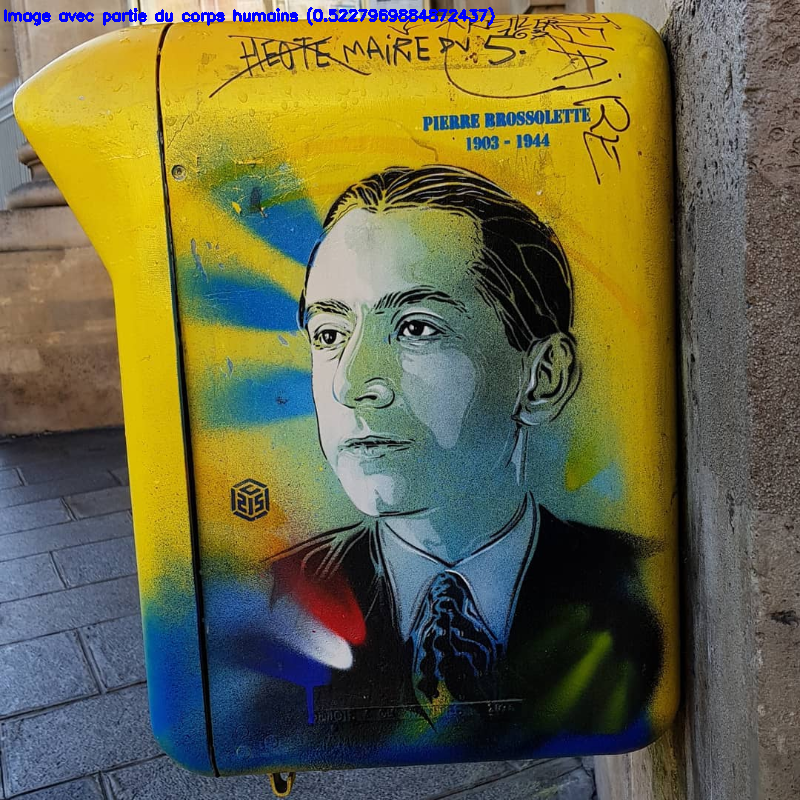

In [77]:
montage = build_montages(results, (800, 800), (1, 1))[0]
cv2.imwrite(MONTAGE_FILENAME, montage)
img = cv2.imread(MONTAGE_FILENAME)

Image(filename=MONTAGE_FILENAME)

In [ ]:
# Example for using build_montage, and not part of the street art model evaluation
'''
import cv2
from imutils import build_montages

IMAGES_PATH = 'dataset/testing'
imagePaths = list(paths.list_images(IMAGES_PATH))
imagePaths = imagePaths[:3]
img_list = []

# load our original input image
for p in imagePaths:
    orig = cv2.imread(p)
    img_list.append(orig)


# convert image list into a montage of 256x256 images tiled in a 3x1 montage
montages = build_montages(img_list, (256, 256), (3, 1))

# iterate through montages and display
for montage in montages:
    cv2.imshow('montage image', montage)
    cv2.waitKey(0)
    '''

KeyError: 'acc'

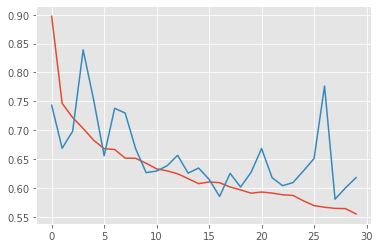

In [88]:
# plot the training loss and accuracyplt
from matplotlib import pyplot as plt
import matplotlib as mpl
N = NUM_EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig(IMAGE_NAME)